In [1]:
import time
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

from config import settings
from train import train_model
from utils_dataset import TripAdvisorData, CustomDataset
from utils_evaluation import (compute_accuracy, compute_confusion_matrix, 
                              show_misclassified, plot_accuracy, plot_training_loss)
from utils_helper import (set_up_device, set_all_seeds, 
                          clear_cuda_memory, save_model, load_model)

c:\Users\Joanna\Desktop\Projects\shopper-sentiment-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

### Set Configurations

In [3]:
DEVICE = set_up_device()
print(DEVICE)
NUM_EPOCHS = settings.config["num_epochs"]
BATCH_SIZE = settings.config["batch_size"]
LEARNING_RATE = settings.config["learning_rate"]

RANDOM_SEED = settings.config["random_seed"]
set_all_seeds(RANDOM_SEED)


cuda:0


### Preprocess Data

In [5]:
trip_advisor = TripAdvisorData()

raw_data = trip_advisor.read_data(data_dir=settings.DATASET_DIR,
                                  data_name=settings.config['data_name'])

clean_data = trip_advisor.preprocess(data=raw_data,
                                     feature_var="Review")

clean_data.head()

,Review,Rating,num_words,label,clean_review
0,nice hotel expensive parking got good deal sta...,4,87,1,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,250,0,ok nothing special charge diamond member hilto...
2,"unique, great stay, wonderful time hotel monac...",5,89,1,unique great stay wonderful time hotel monaco ...
3,"great stay great stay, went seahawk game aweso...",5,191,1,great stay great stay go seahawk game awesome ...
4,love monaco staff husband stayed hotel crazy w...,5,134,1,love monaco staff husband stay hotel crazy wee...


In [8]:
train_data, valid_data, test_data = trip_advisor.create_splits(clean_data,
                                                               target_var="label",
                                                               train_prop=0.8, 
                                                               valid_prop=0.1, 
                                                               test_prop=0.1)

In [9]:
train_texts = train_data.clean_review.values
train_labels = train_data.label.values

valid_texts = valid_data.clean_review.values
valid_labels = valid_data.label.values

test_texts = test_data.clean_review.values
test_labels = test_data.label.values

### Tokenization

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [11]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

### Dataset Class and Loaders

In [12]:
train_dataset = CustomDataset(encodings=train_encodings,
                                 labels=train_labels)

valid_dataset = CustomDataset(encodings=valid_encodings,
                                 labels=valid_labels)

test_dataset = CustomDataset(encodings=test_encodings,
                                 labels=test_labels)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train Model

In [14]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
clear_cuda_memory()

In [16]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(model=model,
                                                                  num_epochs=NUM_EPOCHS,
                                                                  train_loader=train_loader,
                                                                  valid_loader=valid_loader,
                                                                  test_loader=test_loader,
                                                                  optimizer=optim,
                                                                  device=DEVICE,
                                                                  logging_interval=100)

Epoch: 001/005 | Batch 0000/1831 | Loss: 0.7005
Epoch: 001/005 | Batch 0100/1831 | Loss: 0.3442
Epoch: 001/005 | Batch 0200/1831 | Loss: 0.0931
Epoch: 001/005 | Batch 0300/1831 | Loss: 0.0375
Epoch: 001/005 | Batch 0400/1831 | Loss: 0.2138
Epoch: 001/005 | Batch 0500/1831 | Loss: 0.2505
Epoch: 001/005 | Batch 0600/1831 | Loss: 0.2313
Epoch: 001/005 | Batch 0700/1831 | Loss: 0.1465
Epoch: 001/005 | Batch 0800/1831 | Loss: 0.3054
Epoch: 001/005 | Batch 0900/1831 | Loss: 0.0121
Epoch: 001/005 | Batch 1000/1831 | Loss: 0.1325
Epoch: 001/005 | Batch 1100/1831 | Loss: 0.0205
Epoch: 001/005 | Batch 1200/1831 | Loss: 0.0415
Epoch: 001/005 | Batch 1300/1831 | Loss: 0.0117
Epoch: 001/005 | Batch 1400/1831 | Loss: 0.0406
Epoch: 001/005 | Batch 1500/1831 | Loss: 0.4915
Epoch: 001/005 | Batch 1600/1831 | Loss: 0.3236
Epoch: 001/005 | Batch 1700/1831 | Loss: 0.0014
Epoch: 001/005 | Batch 1800/1831 | Loss: 0.1154
Epoch: 001/005 | Train: 0.98% | Validation: 0.96%
Time elapsed: 11.68 min
Epoch: 002/005

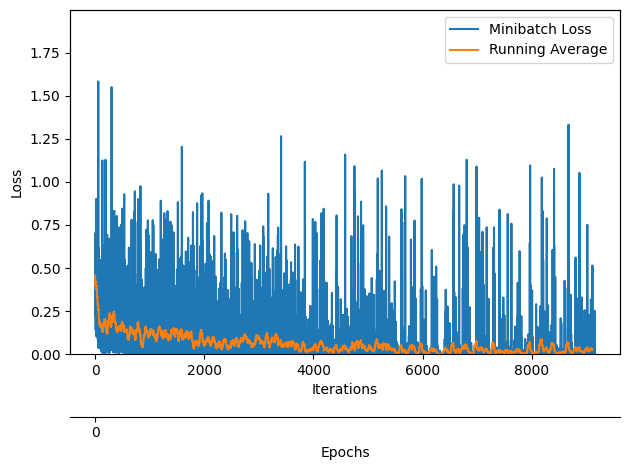

In [17]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=50)

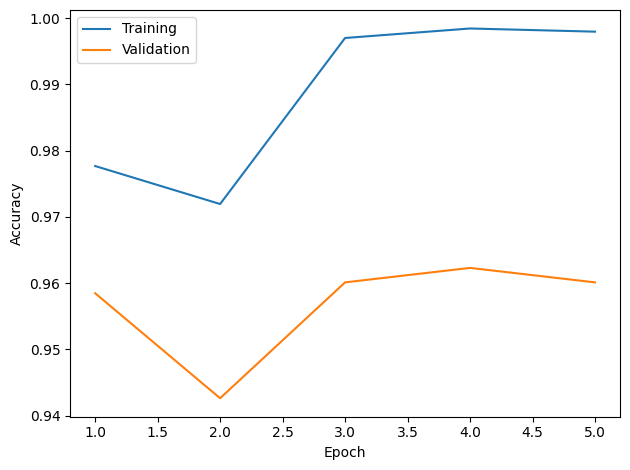

In [18]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

In [19]:
save_model(model=model, target_dir=settings.TRAINED_MODEL_DIR, model_name="model.pt")
save_model(model=optim, target_dir=settings.TRAINED_MODEL_DIR, model_name="optimizer.pt")

[INFO] Saving model to: C:\Users\Joanna\Desktop\Projects\shopper-sentiment-analysis\models\model.pt
[INFO] Saving model to: C:\Users\Joanna\Desktop\Projects\shopper-sentiment-analysis\models\optimizer.pt


In [24]:
# load_model(model=model, target_dir="models", model_name="model.pt")
# load_model(model=optim, target_dir="models", model_name="optimizer.pt")

[INFO] Loading model: models\model.pt
[INFO] Loading model: models\optimizer.pt


              precision    recall  f1-score   support

           0       0.84      0.94      0.88       286
           1       0.99      0.97      0.98      1546

    accuracy                           0.96      1832
   macro avg       0.91      0.95      0.93      1832
weighted avg       0.96      0.96      0.96      1832



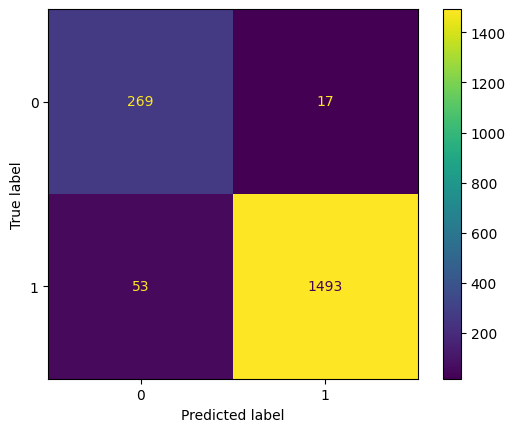

In [20]:
compute_confusion_matrix(model=model,
                         data_loader=test_loader,
                         device=DEVICE)

### Show misclassified reviews

In [21]:
df_error = show_misclassified(model=model,
                              data_loader=test_loader,
                              device=DEVICE,
                              tokenizer=tokenizer)

In [22]:
df_error

,text,true_label,pred_label,probability
0,class glitch review pan pacific hotel singapor...,1,0,"[tensor(0.9946), tensor(0.0054)]"
1,royal club wife stay dec 04 - jan 05. firstly ...,1,0,"[tensor(0.6854), tensor(0.3146)]"
2,funky econo room good hotel careful not econom...,1,0,"[tensor(0.9746), tensor(0.0254)]"
3,ok slightly rough edge book club room intercon...,1,0,"[tensor(0.9971), tensor(0.0029)]"
4,great time talk terrible problem bug mosquito ...,1,0,"[tensor(0.8676), tensor(0.1324)]"
...,...,...,...,...
65,clean room that s let say upfront get room qua...,0,1,"[tensor(0.0004), tensor(0.9996)]"
66,snug twin book chesterfield read review site t...,0,1,"[tensor(0.0972), tensor(0.9028)]"
67,ocean blue disappointing seasoned traveler inc...,0,1,"[tensor(0.0011), tensor(0.9989)]"
68,pro con pet friendly palomar palomar old hilto...,0,1,"[tensor(0.1273), tensor(0.8727)]"
